In [120]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [131]:
# Load the data from the provided .mat file (assuming similar structure as problem 2.1)
data21_path = r'C:\Users\vanes\Desktop\portofolio\git\μηχανικη_μαθηση\hw2 (1)\data21.mat'
data22_path = r'C:\Users\vanes\Desktop\portofolio\git\μηχανικη_μαθηση\hw2 (1)\data22.mat'
data21 = scipy.io.loadmat(data21_path)
data22 = scipy.io.loadmat(data22_path)

# Extract necessary matrices from the loaded data
Xi = data22['X_i']  # Ideal images of digit '8'
Xn = data22['X_n']  # Noisy images

# Reduced latent dimension and increased number of neurons
latent_dim = 10
hidden_neurons = 256

A1 = data21['A_1']
A2 = data21['A_2']
B1 = data21['B_1']
B2 = data21['B_2']
# Parameters
num_iterations = 2000  # Increased number of iterations
N_values = [500, 400, 350, 300]
initial_learning_rate = 0.001  # Slightly higher initial learning rate
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
l2_reg = 0.001  # L2 regularization coefficient



In [132]:
# Function to calculate sigmoid derivative
def sigmoid_derivative(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

# Learning rate decay function
def learning_rate_schedule(iteration, initial_lr, decay_rate=0.001):
    return initial_lr / (1 + decay_rate * iteration)

# Initialize arrays to store costs, damaged, and reconstructed images
J_values_all = np.zeros((num_iterations, 4, len(N_values)))
damaged_imgs = np.zeros((28, 28, 4, len(N_values)))
reconstructed_imgs = np.zeros((28, 28, 4, len(N_values)))

In [128]:
# Main loop: Iterate over the 4 images and different N values
for img_id in range(4):
    for N_id, N in enumerate(N_values):
        X_i_col = Xi[:, img_id]
        X_n_col = Xn[:, img_id]
        non_lost_part = X_n_col[:N].reshape(N, 1)  # Ensure non_lost_part is (N, 1) for each image
        
        # Initialize Z as a single latent vector (shape: (latent_dim, 1)) with Xavier initialization
        Z = np.random.randn(latent_dim, 1) * np.sqrt(1 / latent_dim)
        
        # Define T matrix for masking
        T = np.eye(784)[:N, :]
        
        # Create damaged image with missing pixels
        damaged_img = np.copy(X_n_col)
        damaged_img[N:] = 0  # Set lost pixels to black
        damaged_imgs[:, :, img_id, N_id] = np.rot90(damaged_img.reshape(28, 28).T, -1)
        
        # Initialize Adam optimizer variables
        m = np.zeros_like(Z)  # Shape (latent_dim, 1)
        v = np.zeros_like(Z)  # Shape (latent_dim, 1)
        
        # Perform inpainting using Adam
        for i in range(num_iterations):
            # Learning rate decay
            learning_rate = learning_rate_schedule(i, initial_learning_rate)

            # Forward pass with added hidden layer and Leaky ReLU activation
            W1 = np.dot(A1, Z) + B1  # W1 should be (hidden_neurons, 1)
            Z1 = np.maximum(0.01 * W1, W1)  # Leaky ReLU activation
            
            # Hidden layer forward pass
            W2 = np.dot(A2, Z1) + B2  # W2 (784, 1)
            X = 1 / (1 + np.exp(-W2))  # Sigmoid activation
            
            # Compute the gradient of Φ(X)
            diff = np.dot(T, X) - non_lost_part  # The difference term should be (N, 1)
            norm_squared = np.linalg.norm(diff)**2  # Norm of the difference
            U2 = (1 / norm_squared) * (2 * np.dot(T.T, diff))  # Ensure U2 is (784, 1)

            # Compute gradients for backpropagation
            F2 = sigmoid_derivative(W2)  # Derivative of Sigmoid
            F1 = (W1 > 0).astype(float) + 0.01 * (W1 <= 0).astype(float)  # Derivative of Leaky ReLU
            
            V2 = U2 * F2  # V2 should be (784, 1)
            U1 = np.dot(A2.T, V2)  # U1 should be (hidden_neurons, 1)
            V1 = U1 * F1  # V1 should be (hidden_neurons, 1)
            U0 = np.dot(A1.T, V1)  # U0 should be (latent_dim, 1)

            # Ensure gradient has the correct shape (latent_dim, 1)
            gradient = N * U0 + 2 * Z

            # Apply L2 regularization to gradient
            gradient += l2_reg * Z

            # Adam optimizer update
            m = b1 * m + (1 - b1) * gradient
            v = b2 * v + (1 - b2) * (gradient**2)
            m_hat = m / (1 - b1**(i + 1))
            v_hat = v / (1 - b2**(i + 1))
            
            # Update Z
            Z = Z - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            
            # Compute cost and store it
            J = N * np.log(np.linalg.norm(np.dot(T, X) - non_lost_part)**2) + np.linalg.norm(Z)**2 + (l2_reg / 2) * np.sum(np.square(Z))
            J_values_all[i, img_id, N_id] = J
        
        # Generate the reconstructed image
        X_reconstructed = 1 / (1 + np.exp(-W2))  # Sigmoid activation for reconstruction
        reconstructed_imgs[:, :, img_id, N_id] = np.rot90(X_reconstructed.reshape(28, 28).T, -1)

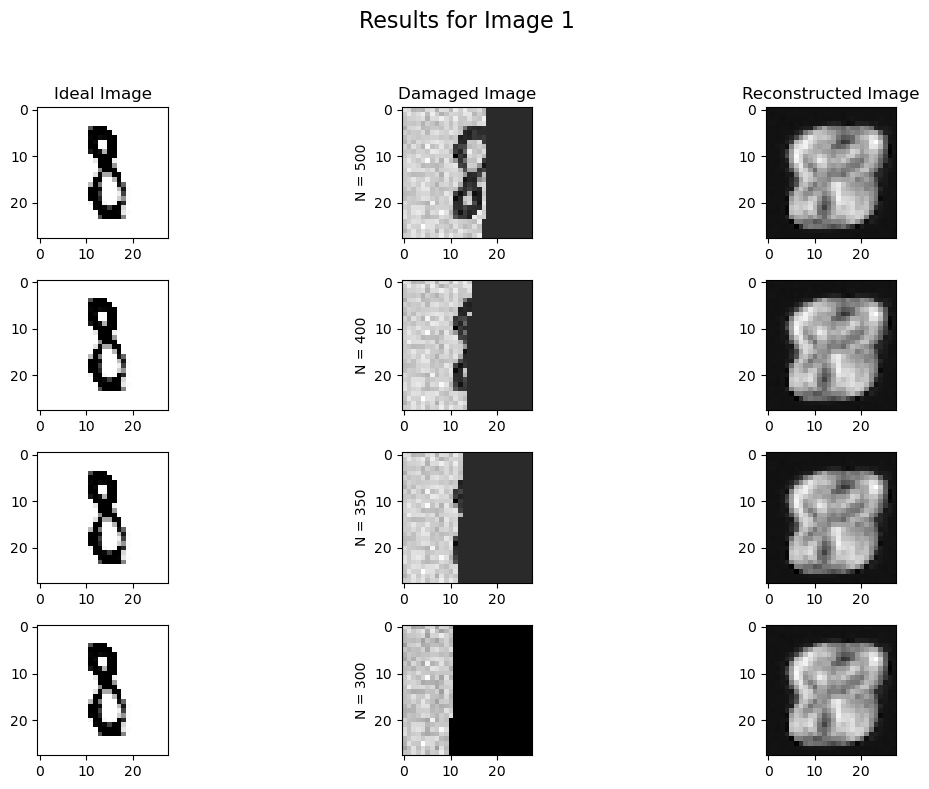

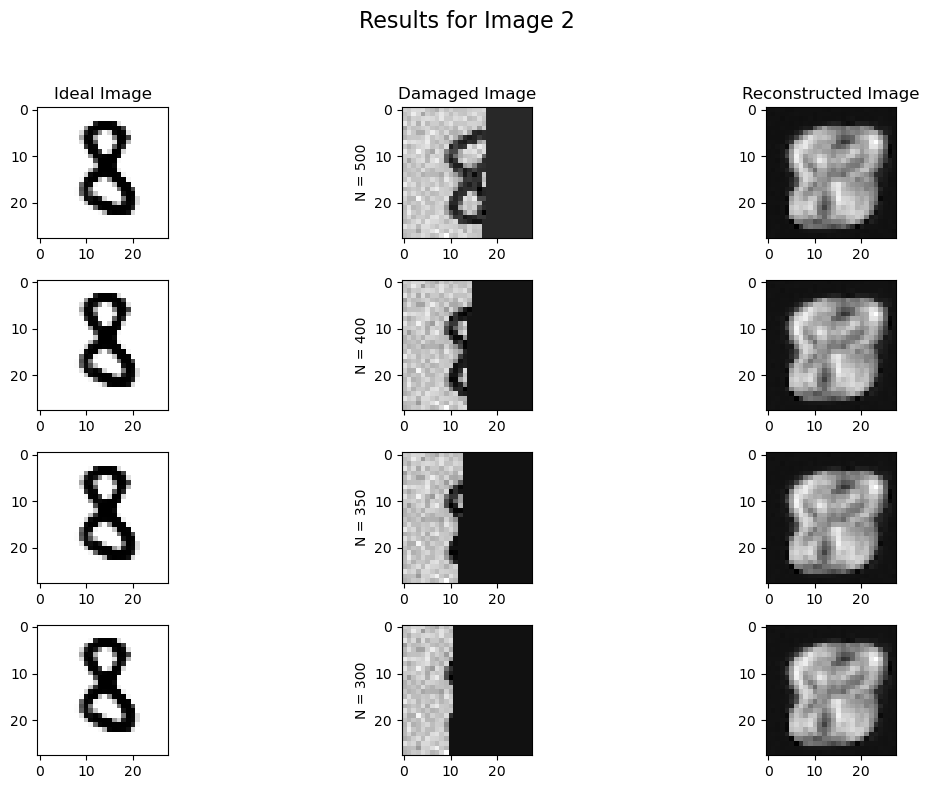

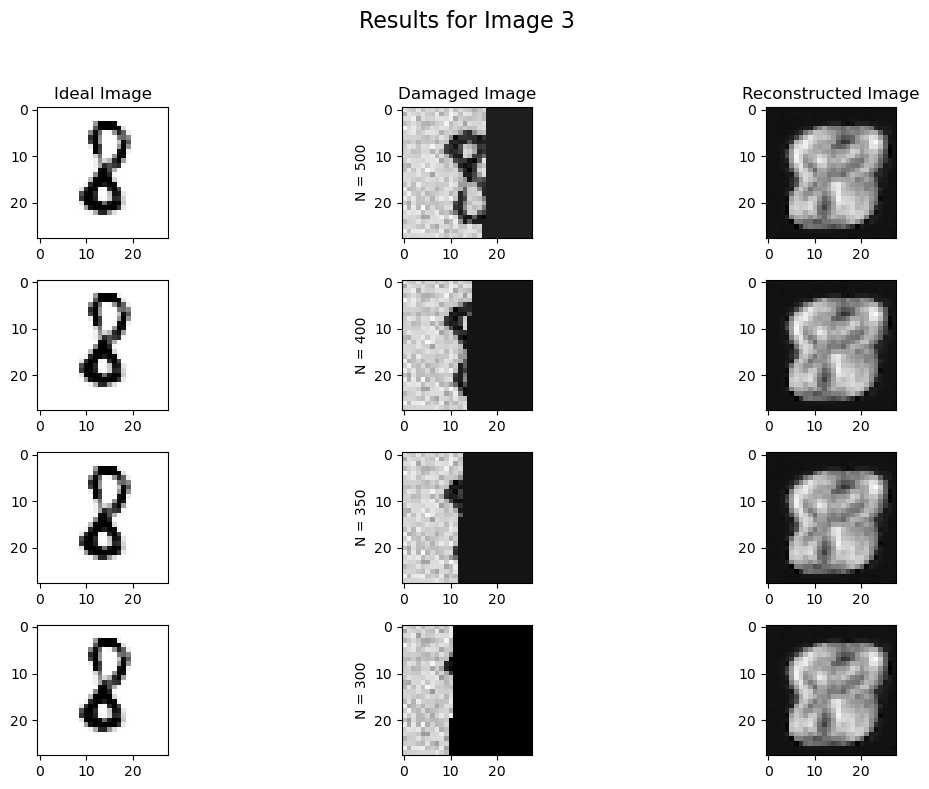

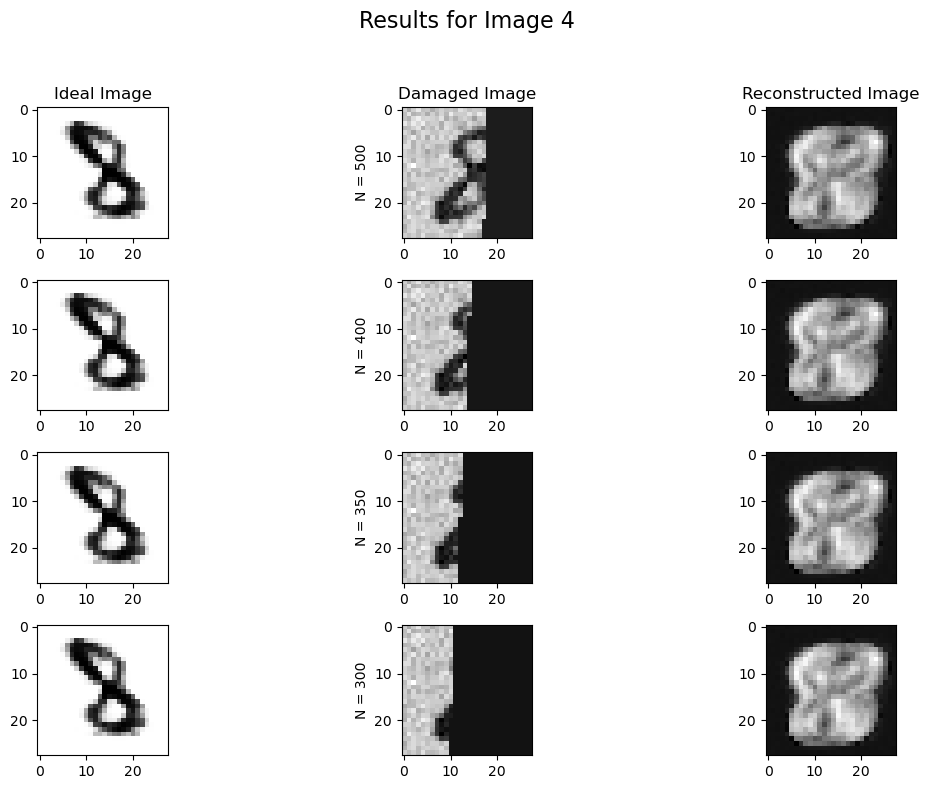

In [129]:
# Updated Plotting Code: Rotate images 90 degrees to the left and add titles
for img_id in range(4):
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Results for Image {img_id + 1}', fontsize=16)
    
    for N_id, N in enumerate(N_values):
        # Rotate the ideal image 90 degrees left
        plt.subplot(len(N_values), 3, N_id * 3 + 1)
        ideal_image = np.rot90(Xi[:, img_id].reshape(28, 28), 1)
        plt.imshow(ideal_image, cmap='gray')
        if N_id == 0:
            plt.title('Ideal Image')
        
        # Rotate the damaged image 90 degrees left
        plt.subplot(len(N_values), 3, N_id * 3 + 2)
        damaged_image = np.rot90(damaged_imgs[:, :, img_id, N_id], 1)
        plt.imshow(damaged_image, cmap='gray')
        if N_id == 0:
            plt.title('Damaged Image')
        plt.ylabel(f'N = {N}')
        
        # Rotate the reconstructed image 90 degrees left
        plt.subplot(len(N_values), 3, N_id * 3 + 3)
        reconstructed_image = np.rot90(reconstructed_imgs[:, :, img_id, N_id], 1)
        plt.imshow(reconstructed_image, cmap='gray')
        if N_id == 0:
            plt.title('Reconstructed Image')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
    plt.show()

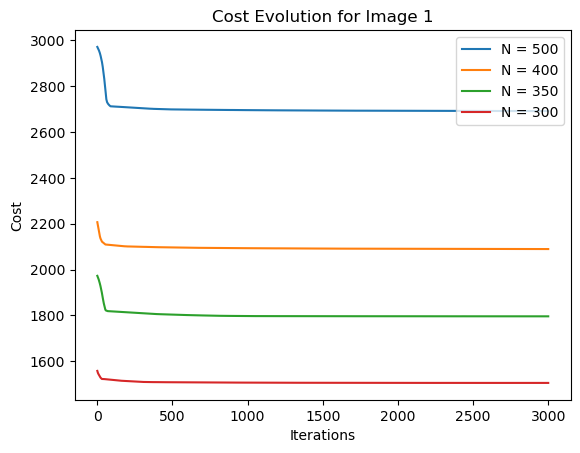

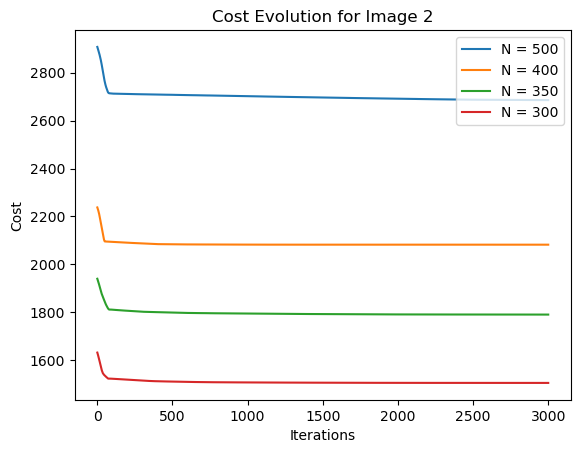

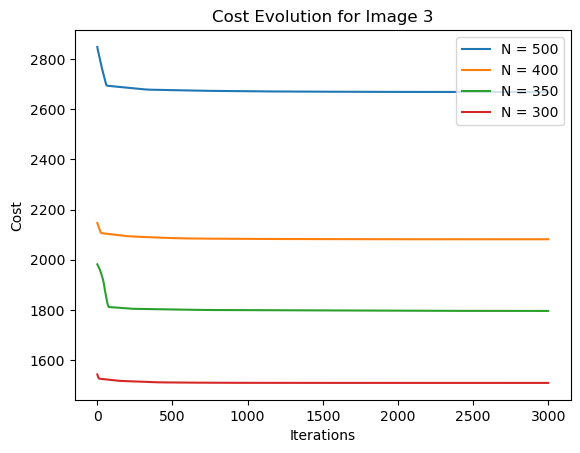

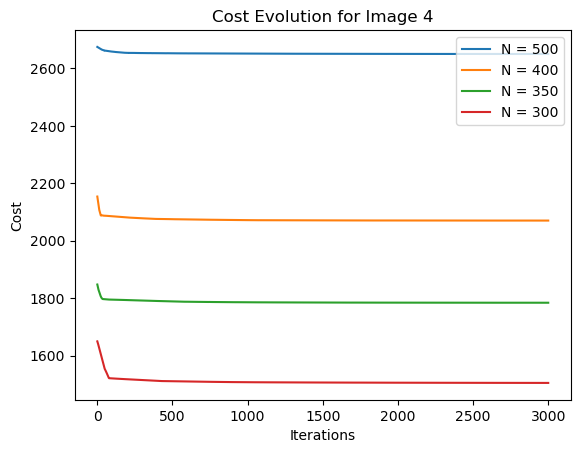

In [130]:
# Plot the cost evolution
for img_id in range(4):
    plt.figure()
    for N_id, N in enumerate(N_values):
        plt.plot(range(num_iterations), J_values_all[:, img_id, N_id], label=f'N = {N}')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(f'Cost Evolution for Image {img_id + 1}')
    plt.legend()
    plt.show()